### This notebook parses GWAS summary statistics and generates 3D Manhattan plots and their projections.
#### `matplotlib`/`pylab` version

In [1]:
import matplotlib.collections
import matplotlib.patches
import mpl_toolkits.mplot3d
import os
import pandas
import pylab
import re

%matplotlib inline

### Parse data and set up axes properties:

In [2]:
GWADataPath = 'Data'
TmpPath = 'Tmp'
ResultsPath = 'Results'

In [3]:
FName = 'TraitAttributesDF.pckl'
TraitAttributesDF = None
if(os.path.exists(os.path.join(GWADataPath,
                               FName))):
    TraitAttributesDF = pandas.read_pickle(
         os.path.join(TmpPath,
                      FName))
    del FName
else:
    FName = 'ENGAGEBioCratesMetaboliteClasses.tsv'
    TraitAttributesDF = pandas.read_csv(os.path.join(GWADataPath,
                                                     FName),
                                        index_col=None,
                                        sep='\t')
    TraitAttributesDF.rename(columns={'# P': 'Index'},
                             inplace=True)
    del FName

    TraitFNameDF = pandas.DataFrame(data=os.listdir(GWADataPath),
                                    columns=['FName'])
    TraitFNameDF.insert(loc=0,
                        column='Path',
                        value=GWADataPath)
    Filter = TraitFNameDF['FName'].str.endswith('.csv')
    TraitFNameDF = TraitFNameDF[Filter].copy()
    del Filter
    TraitFNameDF.reset_index(drop=True,
                             inplace=True)
    TraitFNameDF.insert(loc=0,
                        column='Trait',
                        value=TraitFNameDF['FName'].str.split('_',
                                                              expand=True)[2])
    TraitAttributesDF = TraitAttributesDF.merge(
        right=TraitFNameDF,
        left_on='ENGAGEName',
        right_on='Trait',
        how='right')
    del TraitFNameDF
    TraitAttributesDF['Index'] = TraitAttributesDF.index.values + 1

    FName = 'TraitAttributesDF.pckl'
    TraitAttributesDF.to_pickle(os.path.join(TmpPath,
                                             FName))
    TraitAttributesDF.to_pickle(os.path.join(GWADataPath,
                                             FName))
    del FName

In [4]:
FName = 'GWASummaryStatisticsDF.pckl'
GWASummaryStatisticsDF = None
AxesDF = None
if(os.path.exists(os.path.join(GWADataPath,
                               FName))):
    GWASummaryStatisticsDF = pandas.read_pickle(
         os.path.join(TmpPath,
                      FName))
    del FName
    FName = 'AxesDF.pckl'
    AxesDF = pandas.read_pickle(
         os.path.join(GWADataPath,
                      FName))
    del FName
else:
    GWASummaryStatisticsDF = pandas.DataFrame(columns=['Trait',
                                                       'MarkerName',
                                                       'Allele1',
                                                       'Allele2',
                                                       'Freq1',
                                                       'FreqSE',
                                                       'MinFreq',
                                                       'MaxFreq',
                                                       'Effect',
                                                       'StdErr',
                                                       'P-value',
                                                       'Direction',
                                                       'HetISq',
                                                       'HetChiSq',
                                                       'HetDf',
                                                       'HetPVal'])
    for i in TraitAttributesDF.index:
        Trait = TraitAttributesDF.loc[i,
                                      'Trait']
        TmpDF = pandas.read_csv(
            os.path.join(TraitAttributesDF.loc[i,
                                               'Path'],
                         TraitAttributesDF.loc[i,
                                               'FName']),
            index_col=None,
            sep=',')
        TmpDF.insert(loc=0,
                     column='Trait',
                     value=Trait)
        GWASummaryStatisticsDF = GWASummaryStatisticsDF.append(TmpDF) 
        del TmpDF
    GWASummaryStatisticsDF['Allele1'] = GWASummaryStatisticsDF['Allele1'].str.upper()
    GWASummaryStatisticsDF['Allele2'] = GWASummaryStatisticsDF['Allele2'].str.upper()
    GWASummaryStatisticsDF.insert(loc=0,
                                  column='Index',
                                  value=GWASummaryStatisticsDF.index.values)
    
    FName = 'SNPInfo_MergedCorrected.txt.gz'
    VariantInfoDF = pandas.read_csv(os.path.join(GWADataPath,
                                                 FName),
                                    index_col=None,
                                    sep=' ')
    del FName
    
    GWASummaryStatisticsDF = GWASummaryStatisticsDF.merge(
        right=VariantInfoDF,
        left_on='MarkerName',
        right_on='SNPID',
        how='left')
    
    GWASummaryStatisticsDF.insert(loc=5,
                                  column='Pos',
                                  value=GWASummaryStatisticsDF['position'].values)
    GWASummaryStatisticsDF.insert(loc=5,
                                  column='Chr',
                                  value=GWASummaryStatisticsDF['chr'].values)
    GWASummaryStatisticsDF.insert(
        loc=14,
        column='pP-value',
        value=-pandas.np.real(
            pandas.np.log10(
                GWASummaryStatisticsDF['P-value'])))
    GWASummaryStatisticsDF.drop(labels=['SNPID',
                                        'chr',
                                        'position'],
                                axis=1,
                                inplace=True)

    AxesDict = {}

    AxesDict['Chr'] = {}
    AxesDict['Chr']['Label'] = 'Chromosome'
    Chromosomes = VariantInfoDF['chr'].unique()
    Chromosomes.sort()
    Offset = 10000000
    AxesDict['Chr']['Min'] = float(VariantInfoDF.loc[
            VariantInfoDF['chr']==Chromosomes[0],
            'position'].min() - Offset)
    AxesDict['Chr']['MajorTickRotation'] = 0
    AxesDict['Chr']['MajorTickLabels'] = []
    AxesDict['Chr']['MajorTickLabels'].append('')
    AxesDict['Chr']['MajorTickPositions'] = []
    AxesDict['Chr']['MajorTickPositions'].append(AxesDict['Chr']['Min'])
    AxesDict['Chr']['MinorTickRotation'] = 90
    AxesDict['Chr']['MinorTickLabels'] = []
    AxesDict['Chr']['MinorTickPositions'] = []
    for i in xrange(1,
                    len(Chromosomes)):
        Chr = Chromosomes[i]
        AxesDict['Chr']['MajorTickLabels'].append('')
        AxesDict['Chr']['MajorTickPositions'].append(
            AxesDict['Chr']['MajorTickPositions'][-1] + 
            2.0*Offset +
            float(VariantInfoDF.loc[
                      VariantInfoDF['chr']==Chromosomes[i-1],
                      'position'].max() -
                  VariantInfoDF.loc[
                      VariantInfoDF['chr']==Chromosomes[i-1],
                      'position'].min()))
        AxesDict['Chr']['MinorTickLabels'].append(str(Chromosomes[i-1]))
        Range = AxesDict['Chr']['MajorTickPositions'][-1] - \
            AxesDict['Chr']['MajorTickPositions'][-2]
        AxesDict['Chr']['MinorTickPositions'].append(
            AxesDict['Chr']['MajorTickPositions'][-2] + 
            0.5*Range)  
    AxesDict['Chr']['MajorTickLabels'].append('')
    AxesDict['Chr']['MajorTickPositions'].append(
        AxesDict['Chr']['MajorTickPositions'][-1] + 
        2.0*Offset +
        float(VariantInfoDF.loc[
                  VariantInfoDF['chr']==Chromosomes[-1],
                  'position'].max() -
              VariantInfoDF.loc[
                  VariantInfoDF['chr']==Chromosomes[-1],
                  'position'].min()))
    AxesDict['Chr']['MinorTickLabels'].append(str(Chromosomes[-1]))
    Range = AxesDict['Chr']['MajorTickPositions'][-1] - \
        AxesDict['Chr']['MajorTickPositions'][-2]
    AxesDict['Chr']['MinorTickPositions'].append(
        AxesDict['Chr']['MajorTickPositions'][-2] + 
        0.5*Range)
    AxesDict['Chr']['Max'] = AxesDict['Chr']['MajorTickPositions'][-1]

    AxesDict['Trait'] = {}
    AxesDict['Trait']['Label'] = 'Trait'
    AxesDict['Trait']['Min'] = float(TraitAttributesDF['Index'].min() - 1)
    AxesDict['Trait']['Max'] = float(TraitAttributesDF['Index'].max() + 1)
    AxesDict['Trait']['MajorTickRotation'] = 0
    AxesDict['Trait']['MajorTickLabels'] = TraitAttributesDF['ENGAGEName'].tolist()
    AxesDict['Trait']['MajorTickPositions'] = TraitAttributesDF['Index'].astype(float).tolist()
    AxesDict['Trait']['MinorTickRotation'] = 0
    AxesDict['Trait']['MinorTickLabels'] = [''] * (len(AxesDict['Trait']['MajorTickLabels'])+1)
    AxesDict['Trait']['MinorTickPositions'] = TraitAttributesDF['Index'].astype(float) - 0.5
    AxesDict['Trait']['MinorTickPositions'] = AxesDict['Trait']['MinorTickPositions'].tolist()
    AxesDict['Trait']['MinorTickPositions'].append(AxesDict['Trait']['MinorTickPositions'][-1]+1.0)

    AxesDict['pP'] = {}
    AxesDict['pP']['Label'] = r'$\mathsf{-\log_{10}\left[p-value\right]}$'
    AxesDict['pP']['Min'] = 0.0
    AxesDict['pP']['Max'] = GWASummaryStatisticsDF['pP-value'].max() + 5.0
    AxesDict['pP']['MajorTickRotation'] = 0
    AxesDict['pP']['MajorTickLabels'] = pandas.np.arange(start=AxesDict['pP']['Min'],
                                                         stop=(AxesDict['pP']['Max']+5.0),
                                                         step=10.0).astype(str).tolist()
    AxesDict['pP']['MajorTickPositions'] = pandas.np.arange(start=AxesDict['pP']['Min'],
                                                         stop=(AxesDict['pP']['Max']+5.0),
                                                         step=10.0).tolist()
    AxesDict['pP']['MinorTickRotation'] = 0
    AxesDict['pP']['MinorTickLabels'] = [''] * (len(AxesDict['pP']['MajorTickLabels'])-1)
    AxesDict['pP']['MinorTickPositions'] = pandas.np.arange(start=AxesDict['pP']['Min'],
                                                            stop=(AxesDict['pP']['Max']+5.0),
                                                            step=10.0) + 5.0
    AxesDict['pP']['MinorTickPositions'] = AxesDict['pP']['MinorTickPositions'].tolist()[:-1]
    
    AxesDF = pandas.DataFrame(data=AxesDict)
    
    FName = 'AxesDF.pckl'
    AxesDF.to_pickle(os.path.join(TmpPath,
                                  FName))
    AxesDF.to_pickle(os.path.join(GWADataPath,
                                  FName))
    del FName
    
    GWASummaryStatisticsDF.insert(loc=7,
                                  column='MHPos',
                                  value=GWASummaryStatisticsDF['Pos'].astype(float).values)
    Chromosomes = GWASummaryStatisticsDF['Chr'].unique()
    Chromosomes.sort()
    for Chr in Chromosomes:
        Filter = GWASummaryStatisticsDF['Chr'] == Chr
        GWASummaryStatisticsDF.loc[Filter,
                                   'MHPos'] = \
            GWASummaryStatisticsDF.loc[Filter,
                                       'MHPos'] + \
                AxesDF.loc['MajorTickPositions',
                           'Chr'][Chr-1] + \
                Offset
        del Filter
        
    GWASummaryStatisticsDF = GWASummaryStatisticsDF.merge(right=TraitAttributesDF[['Trait',
                                                                                   'Class']],
                                                          left_on='Trait',
                                                          right_on='Trait',
                                                          how='left')
    
    GWASummaryStatisticsDF['TraitIndex'] = 0
    for T in GWASummaryStatisticsDF['Trait'].unique():
        Filter = GWASummaryStatisticsDF['Trait'] == T
        GWASummaryStatisticsDF.loc[Filter,
                                   'TraitIndex'] = TraitAttributesDF.loc[TraitAttributesDF['ENGAGEName']==T,
                                                                         'Index'].values[0]
        del Filter
    
    FName = 'GWASummaryStatisticsDF.pckl'
    GWASummaryStatisticsDF.to_pickle(os.path.join(TmpPath,
                                                  FName))
    GWASummaryStatisticsDF.to_pickle(os.path.join(GWADataPath,
                                                  FName))
    del FName

### Setting *z*-axis extrema:

In [5]:
ZMin = GWASummaryStatisticsDF['pP-value'].min()
ZMax = GWASummaryStatisticsDF['pP-value'].max()

### Setting *z*-axis significance levels:

In [6]:
ZSignFilter = (GWASummaryStatisticsDF['pP-value'] > (-pandas.np.log10(5.0e-8 / float(46))))
ZSuggFilter = (GWASummaryStatisticsDF['pP-value'] >= (-pandas.np.log10(5.0e-6)))
ZSuggFilter = ZSuggFilter & (GWASummaryStatisticsDF['pP-value'] <= (-pandas.np.log10(5.0e-8 / float(46))))

### Parse/set `LocusInfoDF`:

In [7]:
LocusInfoDF = pandas.read_csv(os.path.join(GWADataPath,
                                           'LeadSNPPerLocus.tsv'),
                              index_col=None,
                              sep='\t')
LocusInfoDF = LocusInfoDF.merge(right=GWASummaryStatisticsDF[['MarkerName',
                                                              'MHPos']],
                                left_on=['LeadMetabolomicSNP'],
                                right_on=['MarkerName'],
                                how='left')

### Add `Class` colors and `Class` polygon properties to `TraitAttributesDF`:

In [8]:
ClassColorDict = {'acylcarnitines': '#66FF33',
                  'aminoacids': '#00CCFF',
                  'glycerophospholipids': '#CC00FF',
                  'sphingolipids': '#FFFF00',
                  'sugars': '#B6B6B6'}
TraitAttributesDF['Color'] = ''
TraitAttributesDF['YMin'] = 0.0
TraitAttributesDF['YMax'] = 0.0
for K in ClassColorDict.iterkeys():
    Filter = TraitAttributesDF['Class']==K
    TraitAttributesDF.loc[Filter,
                          'Color'] = ClassColorDict[K]
    TraitAttributesDF.loc[Filter,
                          'YMin'] = \
        TraitAttributesDF.loc[Filter,
                              'Index'].astype(float).min() - 0.5
    TraitAttributesDF.loc[Filter,
                      'YMax'] = \
        TraitAttributesDF.loc[Filter,
                              'Index'].astype(float).max() + 0.5
    del Filter

### Set figure properties:

In [9]:
figwidth = 7.087  # in inches: 180mm (= 2 column)
golden_mean = (pandas.np.sqrt(5.0) - 1.0) / 2.0  # Aesthetic ratio
figheight = figwidth * golden_mean
fig_size = [figwidth, figheight]
params = {'axes.labelsize': 10,
          'axes.linewidth': 1.0,
          'grid.color': '0.75',
          'grid.linewidth': 0.5,
          'grid.linestyle': ':',
          'axes.axisbelow': False,
          'font.size': 8,
          'legend.fontsize': 10,
          'xtick.labelsize': 10,
          'ytick.labelsize': 10,
          'figure.figsize': fig_size}
left = 0.0775
bottom = 0.095
right = 1.0 - 1.5 * left
top = 1.0 - 1.175 * bottom

pylab.rcParams.update(params)
pylab.rcParams.update({'mathtext.fontset': 'custom'})
pylab.rcParams.update({'mathtext.it': 'sans:italic'})

Rectangle = [left, bottom, right, top]

ScatterPointSize = 5.0

### Plot `Chr`-`TraitIndex`-`pP` projection figure and save to
#### "`./Results/Manhattan3DStill.pdf`":

/home/r.pool/anaconda2/lib/python2.7/site-packages/matplotlib/font_manager.py:1288: UserWarning: findfont: Font family [u'cursive'] not found. Falling back to Bitstream Vera Sans
  (prop.get_family(), self.defaultFamily[fontext]))


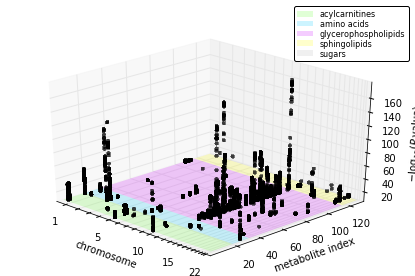

In [10]:
ClassColorDict = {'acylcarnitines': '#66FF33',
                  'aminoacids': '#00CCFF',
                  'glycerophospholipids': '#CC00FF',
                  'sphingolipids': '#FFFF00',
                  'sugars': '#B6B6B6'}

PylabFigure = pylab.figure()
PylabFigure.clf()
PylabAxis = PylabFigure.add_subplot(1,
                                    1,
                                    1,
                                    projection='3d')

PylabAxis.set_xlabel('chromosome')
PylabAxis.set_ylabel('metabolite index')
PylabAxis.set_zlabel(r'$\mathsf{-log}_\mathsf{10}\mathsf{(}\mathit{P}\/\mathsf{value)}$')

PylabAxis.set_xlim3d([AxesDF.loc['Min',
                                 'Chr'],
                      AxesDF.loc['Max',
                                 'Chr']])
PylabAxis.set_ylim3d([TraitAttributesDF['Index'].astype(float).min()-0.62,
                      TraitAttributesDF['Index'].astype(float).max()+0.62])
PylabAxis.set_zlim3d([pandas.np.real(-pandas.np.log10(5.0e-8 / 46.0)),
                      ZMax + 5.0])

PylabAxis.xaxis.set_ticks_position('bottom')
PylabAxis.xaxis.set_ticks(AxesDF.loc['MinorTickPositions',
                                     'Chr'])
ChrTckLbls = []
ChrTckLbls.extend(
    AxesDF.loc['MinorTickLabels',
               'Chr'])
for i in xrange(1,4):
    ChrTckLbls[i] = ''
for i in xrange(5,9):
    ChrTckLbls[i] = ''
for i in xrange(10,14):
    ChrTckLbls[i] = ''
for i in xrange(15,21):
    ChrTckLbls[i] = ''
PylabAxis.xaxis.set_ticklabels(ChrTckLbls)

Classes = TraitAttributesDF['Class'].unique()
Cll = []
Colors = []
Lbls = []
for i in xrange(len(Classes)):
    Class = Classes[i]
    XMin = PylabAxis.get_xlim3d()[0]
    XMax = PylabAxis.get_xlim3d()[1]
    Filter = TraitAttributesDF['Class'] == Class
    YMin = TraitAttributesDF.loc[Filter,
                                 'YMin'].unique()[0]
    YMax = TraitAttributesDF.loc[Filter,
                                 'YMax'].unique()[0]
    Clr = TraitAttributesDF.loc[Filter,
                                'Color'].unique()[0]
    Colors.append(Clr)
    Lbls.append(
        re.sub('aminoacids',
               'amino acids',
               Class))
    x = [XMin,
         XMax,
         XMax,
         XMin]
    y = [YMin,
         YMin,
         YMax,
         YMax]
    Verts = [zip(x, 
                 y)]
    Poly = matplotlib.collections.PolyCollection(Verts)
    Poly.set_alpha(0.2)
    Poly.set_linewidths(0)
    Poly.set_antialiaseds(True)
    Poly.set_label(Class)
    Poly.set_color([Clr])
    PylabAxis.add_collection3d(Poly,
                               zs=[PylabAxis.get_zlim3d()[0]]*len(x))
    Cll.append(PylabAxis.collections[-1])

PlyCll = []
PlyCll.extend(Cll)
del Cll
H = []
for j in xrange(len(Colors)):
    H.append(
        matplotlib.patches.Patch(
            color=Colors[j],
            label=Lbls[j],
            alpha=0.2,
            lw=0.0))

PylabAxis.scatter(xs=GWASummaryStatisticsDF.loc[ZSignFilter,
                                                'MHPos'],
                  ys=GWASummaryStatisticsDF.loc[ZSignFilter,
                                                'TraitIndex'],
                  zs=GWASummaryStatisticsDF.loc[ZSignFilter,
                                                'pP-value'],
                  s=ScatterPointSize,
                  c='black',
                  marker='o',
                  alpha=0.5,
                  antialiased=False,
                  edgecolors='none',
                  depthshade=True)

Legend = PylabAxis.legend(H,
                          Lbls,
                          bbox_to_anchor=(1.025, 1.09),
                          fancybox=True,
                          labelspacing=0.1,
                          fontsize=8)

Elevation = 30
Angle = 315

PylabAxis.figure.set_size_inches(w=figwidth,
                                 h=figheight)
PylabAxis.view_init(elev=Elevation,
                    azim=Angle)

pylab.savefig(os.path.join(ResultsPath,
                           'Manhattan3DStill.pdf'))

### Plot `Chr`-`TraitIndex` projection figure and save to
#### "`./Results/ManhattanHelicopterView.pdf`":

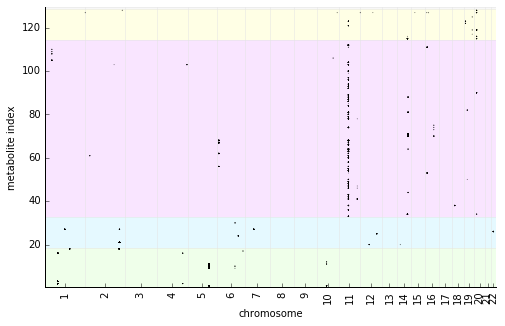

In [11]:
ClassColorDict = {'acylcarnitines': '#66FF33',
                  'aminoacids': '#00CCFF',
                  'glycerophospholipids': '#CC00FF',
                  'sphingolipids': '#FFFF00',
                  'sugars': '#B6B6B6'}

PylabFigure = pylab.figure()
PylabFigure.clf()
PylabAxis = PylabFigure.add_axes(Rectangle)

PylabAxis.set_xlabel('chromosome')
PylabAxis.set_ylabel('metabolite index')

PylabAxis.set_ylim([TraitAttributesDF['Index'].astype(float).min()-0.62,
                    TraitAttributesDF['Index'].astype(float).max()+0.62])
PylabAxis.yaxis.set_ticks_position('left')

for i in xrange(len(AxesDF.loc['MajorTickPositions',
                               'Chr'])):
    PylabAxis.plot(pandas.np.array([AxesDF.loc['MajorTickPositions',
                                               'Chr'][i]] * 2),
                   pandas.np.array(PylabAxis.get_ylim()),
                   lw=0.5,
                   color='#E4E4E4')

for L in PylabAxis.yaxis.get_ticklabels():
    L.set_horizontalalignment('right')

PylabAxis.set_xlim([AxesDF.loc['Min',
                               'Chr'],
                    AxesDF.loc['Max',
                               'Chr']])
PylabAxis.xaxis.set_ticks_position('bottom')
PylabAxis.xaxis.set_ticks(AxesDF.loc['MinorTickPositions',
                                     'Chr'])
PylabAxis.xaxis.set_ticklabels(AxesDF.loc['MinorTickLabels',
                                          'Chr'])

for L in PylabAxis.xaxis.get_ticklabels():
    L.set_rotation(AxesDF.loc['MinorTickRotation',
                              'Chr'])

Classes = TraitAttributesDF['Class'].unique()
for j in xrange(len(Classes)):
    Class = Classes[j]
    Filter = TraitAttributesDF['Class'] == Class
    Ymin = TraitAttributesDF.loc[Filter,
                                 'YMin'].unique()[0]
    Ymax = TraitAttributesDF.loc[Filter,
                                 'YMax'].unique()[0]
    PylabAxis.plot(pandas.np.array(PylabAxis.get_xlim()),
                   pandas.np.array([Ymin] * 2),
                   lw=0.5,
                   color='#E4E4E4')
    if(j == (len(Classes) - 1)):
        PylabAxis.plot(pandas.np.array(PylabAxis.get_xlim()),
                       pandas.np.array([Ymax] * 2),
                       lw=0.5,
                       color='#E4E4E4')
    del Filter

Cll = []
for Class in Classes:
    Xmin = PylabAxis.get_xlim()[0]
    Xmax = PylabAxis.get_xlim()[1]
    Filter = TraitAttributesDF['Class'] == Class
    Ymin = TraitAttributesDF.loc[Filter,
                                 'YMin'].unique()[0]
    Ymax = TraitAttributesDF.loc[Filter,
                                 'YMax'].unique()[0]
    Clr = TraitAttributesDF.loc[Filter,
                                'Color'].unique()[0]
    x = [Xmin, Xmax, Xmax, Xmin]
    y = [Ymin, Ymin, Ymax, Ymax]
    Verts = [zip(x, y)]
    Poly = matplotlib.collections.PolyCollection(Verts)
    Poly.set_alpha(0.1)
    Poly.set_linewidths(0)
    Poly.set_antialiaseds(True)
    Poly.set_label(Class)
    Poly.set_color([Clr])
    PylabAxis.add_collection(Poly)
    Cll.append(PylabAxis.collections[-1])
    del Filter

PylabAxis.scatter(GWASummaryStatisticsDF.loc[ZSignFilter,
                                             'MHPos'],
                  GWASummaryStatisticsDF.loc[ZSignFilter,
                                             'TraitIndex'],
                  s=1.5*GWASummaryStatisticsDF['pP-value']/ZMax+1.0,
                  color='black',
                  marker='o',
                  alpha=0.5,
                  antialiased=True,
                  edgecolors='none',
                  zorder=1000)

PylabAxis.spines['right'].set_visible(False)
PylabAxis.spines['top'].set_visible(False)

pylab.savefig(os.path.join(ResultsPath,
                           'ManhattanHelicopterView.pdf'))

### Plot `Chr`-`pP` projection figure and save to
#### "`./Results/ManhattanAllSignificantWithAnnotations.pdf`":

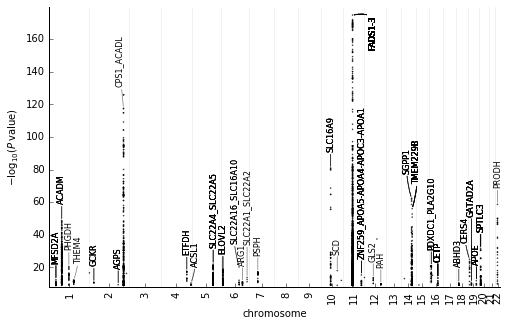

In [12]:
PylabFigure = pylab.figure()
PylabFigure.clf()
PylabAxis = PylabFigure.add_axes(Rectangle)

PylabAxis.set_xlabel('chromosome')
PylabAxis.set_ylabel(
    r'$\mathsf{-log}_\mathsf{10}\mathsf{(}\mathit{P}\/\mathsf{value)}$')

PylabAxis.set_ylim([pandas.np.real(-pandas.np.log10(5.0e-8 / 46.0)) - 1.0, ZMax + 5.0])
PylabAxis.yaxis.set_ticks_position('left')

for i in xrange(len(AxesDF.loc['MajorTickPositions',
                               'Chr'])):
    PylabAxis.plot(pandas.np.array([AxesDF.loc['MajorTickPositions',
                                               'Chr'][i]] * 2),
                   pandas.np.array(PylabAxis.get_ylim()),
                   lw=0.5,
                   color='#E4E4E4')

PylabAxis.scatter(GWASummaryStatisticsDF.loc[ZSignFilter,
                                             'MHPos'],
                  GWASummaryStatisticsDF.loc[ZSignFilter,
                                             'pP-value'],
                  s=0.5 * float(ScatterPointSize),
                  color='black',
                  marker='o',
                  alpha=0.75,
                  antialiased=True,
                  edgecolors='none',
                  zorder=1000)

for L in PylabAxis.yaxis.get_ticklabels():
    L.set_horizontalalignment('right')

PylabAxis.set_xlim([AxesDF.loc['Min',
                               'Chr'],
                    AxesDF.loc['Max',
                               'Chr']])
PylabAxis.xaxis.set_ticks_position('bottom')
PylabAxis.xaxis.set_ticks(AxesDF.loc['MinorTickPositions',
                                     'Chr'])
PylabAxis.xaxis.set_ticklabels(AxesDF.loc['MinorTickLabels',
                                          'Chr'])

for L in PylabAxis.xaxis.get_ticklabels():
    L.set_rotation(AxesDF.loc['MinorTickRotation',
                              'Chr'])

XPosition = []
YPosition = []
HAlign = []
VAlign = []
for j in xrange(LocusInfoDF.shape[0]):
    Pos = LocusInfoDF['MHPos'].astype(float)[j]
    Mrkr = LocusInfoDF['LeadMetabolomicSNP'].astype(str)[j]
    Trait = TraitAttributesDF.loc[
        TraitAttributesDF['BioCrateshortName']==LocusInfoDF['LeadMetabolite'][j],
        'Trait'].values[0]
    Filter = GWASummaryStatisticsDF['Trait'] == Trait
    Filter = Filter & (GWASummaryStatisticsDF['MarkerName'] == Mrkr)
    Filter = Filter & ZSignFilter

    if(LocusInfoDF['LocusName'][j] == 'TMEM229B'):
        HAlign.append('left')
        VAlign.append('bottom')
        YPosition.append(GWASummaryStatisticsDF.loc[Filter,
                                                    'pP-value']+7.0)
        XPosition.append(GWASummaryStatisticsDF.loc[Filter,
                                                    'MHPos'])
    elif(LocusInfoDF['LocusName'][j] == 'ACSL1'):
        HAlign.append('left')
        VAlign.append('bottom')
        YPosition.append(GWASummaryStatisticsDF.loc[Filter,
                                                    'pP-value']+2.0)
        XPosition.append(GWASummaryStatisticsDF.loc[Filter,
                                                    'MHPos'])
    elif(LocusInfoDF['LocusName'][j] == 'THEM4'):
        HAlign.append('left')
        VAlign.append('bottom')
        YPosition.append(GWASummaryStatisticsDF.loc[Filter,
                                                    'pP-value']+2.0)
        XPosition.append(GWASummaryStatisticsDF.loc[Filter,
                                                    'MHPos'])
    elif(LocusInfoDF['LocusName'][j] == 'CERS4'):
        HAlign.append('right')
        VAlign.append('bottom')
        YPosition.append(GWASummaryStatisticsDF.loc[Filter,
                                                    'pP-value']+2.0)
        XPosition.append(GWASummaryStatisticsDF.loc[Filter,
                                                    'MHPos'])
    elif(LocusInfoDF['LocusName'][j] == 'SGPP1'):
        HAlign.append('right')
        VAlign.append('bottom')
        YPosition.append(GWASummaryStatisticsDF.loc[Filter,
                                                    'pP-value']+7.0)
        XPosition.append(GWASummaryStatisticsDF.loc[Filter,
                                                    'MHPos'])
    elif(LocusInfoDF['LocusName'][j] == 'GATAD2A'):
        HAlign.append('center')
        VAlign.append('bottom')
        YPosition.append(GWASummaryStatisticsDF.loc[Filter,
                                                    'pP-value']+32.5)
        XPosition.append(GWASummaryStatisticsDF.loc[Filter,
                                                    'MHPos'])
    elif(LocusInfoDF['LocusName'][j] == 'SLC22A1_SLC22A2'):
        HAlign.append('center')
        VAlign.append('bottom')
        YPosition.append(GWASummaryStatisticsDF.loc[Filter,
                                                    'pP-value']+12.0)
        XPosition.append(GWASummaryStatisticsDF.loc[Filter,
                                                    'MHPos'])
    elif(LocusInfoDF['LocusName'][j] == 'SLC22A16_SLC16A10'):
        HAlign.append('right')
        VAlign.append('bottom')
        YPosition.append(GWASummaryStatisticsDF.loc[Filter,
                                                    'pP-value']+6.0)
        XPosition.append(GWASummaryStatisticsDF.loc[Filter,
                                                    'MHPos'])
    elif(LocusInfoDF['LocusName'][j] == 'CPS1_ACADL'):
        HAlign.append('right')
        VAlign.append('bottom')
        YPosition.append(GWASummaryStatisticsDF.loc[Filter,
                                                    'pP-value']+5.0)
        XPosition.append(GWASummaryStatisticsDF.loc[Filter,
                                                    'MHPos'])
    elif(LocusInfoDF['LocusName'][j] == 'FADS1-3'):
        HAlign.append('left')
        VAlign.append('top')
        YPosition.append(GWASummaryStatisticsDF.loc[Filter,
                                                    'pP-value']-8.0)
        XPosition.append(GWASummaryStatisticsDF.loc[Filter,
                                                    'MHPos']+100000000.0)
    else:
        YPosition.append(GWASummaryStatisticsDF.loc[Filter,
                                                    'pP-value']+2.0)
        XPosition.append(GWASummaryStatisticsDF.loc[Filter,
                                                    'MHPos'])
        HAlign.append('center')
        VAlign.append('bottom')
        
    del Filter

LocusInfoDF['XPos'] = XPosition
LocusInfoDF['YPos'] = YPosition
LocusInfoDF['HAlign'] = HAlign
LocusInfoDF['VAlign'] = VAlign

for j in xrange(LocusInfoDF.shape[0]):
    Mrkr = LocusInfoDF['LeadMetabolomicSNP'].astype(str)[j]
    Trait = TraitAttributesDF.loc[
        TraitAttributesDF['BioCrateshortName']==LocusInfoDF['LeadMetabolite'][j],
        'Trait'].values[0]
    Filter = GWASummaryStatisticsDF['Trait'] == Trait
    Filter = Filter & (GWASummaryStatisticsDF['MarkerName'] == Mrkr)
    Filter = Filter & ZSignFilter
    
    AProps = dict(arrowstyle='-',
                  color='black',
                  alpha=0.5,
                  connectionstyle='arc3,rad=0.0',
                  relpos=(0.5, 0.5),
                  shrinkB=2,
                  shrinkA=0,
                  lw=0.75)
    if(LocusInfoDF['LocusName'][j] == 'TMEM229B'):
        AProps = dict(arrowstyle='-',
                      color='black',
                      alpha=0.5,
                      connectionstyle='arc3,rad=-0.1',
                      relpos=(0.5, 0.5),
                      shrinkB=2,
                      shrinkA=0,
                      lw=0.75)
    if(LocusInfoDF['LocusName'][j] == 'ACSL1'):
        AProps = dict(arrowstyle='-',
                      color='black',
                      alpha=0.5,
                      connectionstyle='arc3,rad=-0.1',
                      relpos=(0.5, 0.5),
                      shrinkB=2,
                      shrinkA=0,
                      lw=0.75)
    if(LocusInfoDF['LocusName'][j] == 'THEM4'):
        AProps = dict(arrowstyle='-',
                      color='black',
                      alpha=0.5,
                      connectionstyle='arc3,rad=-0.1',
                      relpos=(0.5, 0.5),
                      shrinkB=2,
                      shrinkA=0,
                      lw=0.75)
    if(LocusInfoDF['LocusName'][j] == 'CERS4'):
        AProps = dict(arrowstyle='-',
                      color='black',
                      alpha=0.5,
                      connectionstyle='arc3,rad=0.1',
                      relpos=(0.5, 0.5),
                      shrinkB=2,
                      shrinkA=0,
                      lw=0.75)
    if(LocusInfoDF['LocusName'][j] == 'SGPP1'):
        AProps = dict(arrowstyle='-',
                      color='black',
                      alpha=0.5,
                      connectionstyle='arc3,rad=0.1',
                      relpos=(0.5, 0.5),
                      shrinkB=2,
                      shrinkA=0,
                      lw=0.75)
    if(LocusInfoDF['LocusName'][j] == 'FADS1-3'):
        AProps = dict(arrowstyle='-',
                      color='black',
                      alpha=0.5,
                      connectionstyle='arc3,rad=0.1',
                      relpos=(0.0, 1.0),
                      shrinkB=2,
                      shrinkA=0,
                      lw=0.75)
    if(LocusInfoDF['LocusName'][j] == 'SLC22A16_SLC16A10'):
        AProps = dict(arrowstyle='-',
                      color='black',
                      alpha=0.5,
                      connectionstyle='arc3,rad=0.1',
                      relpos=(0.5, 0.5),
                      shrinkB=2,
                      shrinkA=0,
                      lw=0.75)
    PylabAxis.annotate(LocusInfoDF['LocusName'][j],
                       xy=(GWASummaryStatisticsDF.loc[Filter,
                                                      'MHPos'],
                           GWASummaryStatisticsDF.loc[Filter,
                                                      'pP-value']),
                       xytext=(LocusInfoDF['XPos'][j],
                               LocusInfoDF['YPos'][j] + 8.0),
                       ha=LocusInfoDF['HAlign'][j],
                       va=LocusInfoDF['VAlign'][j],
                       bbox=dict(boxstyle='round',
                                 fc=None,
                                 alpha=0.5,
                                 fill=False,
                                 lw=0.0),
                       arrowprops=AProps,
                       rotation='vertical')

PylabAxis.spines['right'].set_visible(False)
PylabAxis.spines['top'].set_visible(False)

pylab.savefig(os.path.join(ResultsPath,
                           'ManhattanAllSignificantWithAnnotations.pdf'))